In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("bioAI.mplstyle")
import tqdm
import scipy
import umap
import torch
import copy

from methods import RandomWalk2D, place_cells, border_cells, head_direction_cells, HexagonalGCs
from models import JacobianCI

100%|██████████| 5000/5000 [00:06<00:00, 833.15it/s]


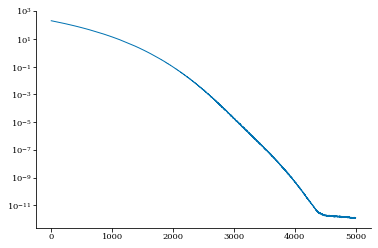

In [3]:
dtype = torch.float32
model = JacobianCI(ncells=7,f=1/(2.5*np.pi),dtype=dtype,lr=1e-2, shift=0, p_magnitude=0, seed=3)
#model = JacobianCI(ncells=7,dtype=dtype,lr=1e-3, shift=0, p_magnitude=0, seed=3)

loss_history = []
for _ in tqdm.trange(5000):
    rs = model.unit_cell.sample(2**8)
    rs = torch.tensor(rs,dtype=dtype)
    loss = model.train_step(rs)
    loss_history.append(loss)
plt.semilogy(loss_history)

In [5]:
activities = model(torch.tensor(model.unit_cell.mesh(50),dtype=dtype)).detach().numpy()
umap_map = umap.UMAP(n_components=3, n_neighbors=100).fit(activities)
low_dim_activities = umap_map.transform(activities)

In [47]:
rw = RandomWalk2D()
rs_trajectory, vs = rw.generate_data(1, 200)
trajectory_activity = model(torch.tensor(rs_trajectory,dtype=dtype)).detach().numpy()
low_dim_trajectory = umap_map.transform(trajectory_activity)

In [48]:
import plotly.graph_objects as go

# Create the 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(x=low_dim_activities[:, 0], y=low_dim_activities[:, 1], z=low_dim_activities[:, 2], 
                                   mode='markers', 
                                   marker=dict(size=5, color=activities[:, 0], colorscale='Viridis', opacity=0.5))])

# Add trajectories
fig.add_trace(go.Scatter3d(x=low_dim_trajectory[:, 0], y=low_dim_trajectory[:, 1], z=low_dim_trajectory[:, 2], mode='lines', line=dict(width=10)))

# Update layout to remove axis and set figure size
fig.update_layout(
    scene=dict(
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        zaxis=dict(visible=False)
    ),
    width=800,  # Set the figure width
    height=600,  # Set the figure height
    margin=dict(l=0, r=0, t=0, b=0)  # Remove whitespace around the plot
)

fig.show()


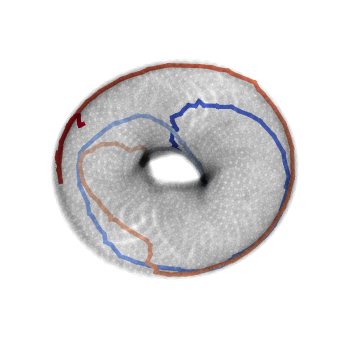

In [66]:
from plotting_functions import set_size

figsize = set_size(fraction=(1/5,1/5),mode='square')

# 3d plot using matplotlib
fig = plt.figure(figsize=figsize, dpi=300)
ax = fig.add_subplot(111, projection='3d')
#ax.scatter(low_dim_activities[:,0], low_dim_activities[:,1], low_dim_activities[:,2], c=activities[:,0], cmap='coolwarm', alpha=0.15, s=2.5)
ax.scatter(low_dim_activities[:,0], low_dim_activities[:,1], low_dim_activities[:,2], alpha=0.05, s=2.5, color='black')
# add trajectory
#ax.plot(low_dim_trajectory[:,0], low_dim_trajectory[:,1], low_dim_trajectory[:,2], color='black')
# plot trajectory with color gradient along the trajectory
for i in range(1, len(low_dim_trajectory)):
    ax.plot(low_dim_trajectory[i-1:i+1,0], low_dim_trajectory[i-1:i+1,1], low_dim_trajectory[i-1:i+1,2], color=plt.cm.coolwarm(i/len(low_dim_trajectory)))

random_elev_offset = np.random.randint(0, 360)
random_azim_offset = np.random.randint(0, 360)
ax.view_init(elev=0+random_elev_offset, azim=0+random_azim_offset)
ax.axis('off')
ax.axis('equal')

fraction = -0.12
mmin, mmax = low_dim_activities.min(0), low_dim_activities.max(0)
ax.set_xlim(mmin[0] - fraction * (mmax[0] - mmin[0]), mmax[0] + fraction * (mmax[0] - mmin[0]))
ax.set_ylim(mmin[1] - fraction * (mmax[1] - mmin[1]), mmax[1] + fraction * (mmax[1] - mmin[1]))
ax.set_zlim(mmin[2] - fraction * (mmax[2] - mmin[2]), mmax[2] + fraction * (mmax[2] - mmin[2]))

padding = 0.0
ax.set_position([-padding, -padding, 1+padding, 1+padding])
ax.patch.set_alpha(0)

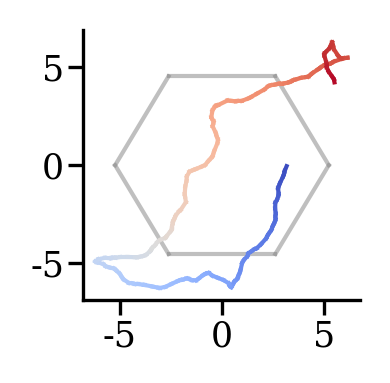

In [68]:
figsize = set_size(fraction=(1/4,1/4),mode='square')
fig, ax = plt.subplots(figsize=figsize, dpi=300)
model.unit_cell.plot(fig, ax, color='grey', alpha=0.5)
# plot trajectory with color gradient along the trajectory
trajectory = np.array(rs_trajectory)
colors = np.linspace(0, 1, len(trajectory))
for i in range(len(trajectory)-1):
    ax.plot(trajectory[i:i+2,0], trajectory[i:i+2,1], color=plt.cm.coolwarm(colors[i]), linewidth=1)
xlims, ylims = ax.get_xlim(), ax.get_ylim()


(-6.8953075667592, 6.905324324031208)

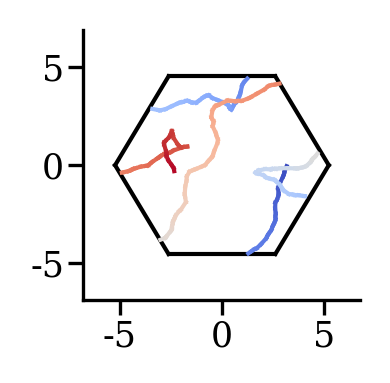

In [51]:
figsize = set_size(fraction=(1/4,1/4),mode='square')
fig, ax = plt.subplots(figsize=figsize, dpi=300)
model.unit_cell.plot(fig, ax, color='black')
# plot trajectory with color gradient along the trajectory
trajectory = np.array(rs_trajectory)
wrapped_trajectory = model.unit_cell.wrap(trajectory)
colors = np.linspace(0, 1, len(wrapped_trajectory))
for i in range(len(trajectory)-1):
    if np.linalg.norm(wrapped_trajectory[i+1]-wrapped_trajectory[i]) < 1:
        ax.plot(wrapped_trajectory[i:i+2,0], wrapped_trajectory[i:i+2,1], color=plt.cm.coolwarm(colors[i]), linewidth=1)

ax.set_xlim(xlims)
ax.set_ylim(ylims)

In [70]:
np.linalg.norm(np.diff(trajectory, axis=0), axis=1).sum() * np.sqrt(model.scale.detach().numpy())

15.075227210522748

In [53]:
np.linalg.norm(np.diff(trajectory_activity, axis=0), axis=1).sum() #* np.sqrt(model.scale.detach().numpy())

15.054821

In [12]:
model.scale, np.sqrt(model.scale.detach().numpy())

(Parameter containing:
 tensor(0.1659, requires_grad=True),
 0.4073406)